## Residual Networks Models
Blablabla
### Installation and Import Checks

In [11]:
%pip install tensorflow==2.10
%pip install scikit-learn
%pip install matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
# Machine Learning
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet152
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# Plotting
import matplotlib.pyplot as plt

### Optional: GPU Acceleration Check
Checks Tensorflow Version and GPU detection. 
If GPU detected, output should be something like "Num GPUs Available:  1"

In [13]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices()
print("Physical Devices:", physical_devices)

TensorFlow version: 2.10.0
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load and Split Prepared Data
Loads in preprocessed data from the ./prepared_data directory for x and y features. Splits for training and testing 80/20 ratio

In [14]:
# Load the data
x_input = np.load('prepared_data/x_input_combined.npy')
y_output = np.load('prepared_data/y_output_combined.npy')

# Ensure y is one-hot encoded if not already
y_output = to_categorical(y_output, num_classes=4)  # Assuming there are 4 classes

# Split the data into training and testing sets
x_input_train, x_input_test, y_output_train, y_output_test = train_test_split(x_input, y_output, test_size=0.2, random_state=42)

# Printing Dimensions of data
print(f'X Training Data\nNumber of Rows: {x_input_train.shape[0]}\nPixel Dimensions: {x_input_train.shape[1]}x{x_input_train.shape[2]}x{x_input_train.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_train.shape[0]}\nNumber of Classes: {y_output_train.shape[1]}\n')
print(f'X Testing Data\nNumber of Rows: {x_input_test.shape[0]}\nPixel Dimensions: {x_input_test.shape[1]}x{x_input_test.shape[2]}x{x_input_test.shape[3]}\n')
print(f'Y Training Data\nNumber of Rows: {y_output_test.shape[0]}\nNumber of Classes: {y_output_test.shape[1]}')

X Training Data
Number of Rows: 1536
Pixel Dimensions: 128x128x3

Y Training Data
Number of Rows: 1536
Number of Classes: 4

X Testing Data
Number of Rows: 384
Pixel Dimensions: 128x128x3

Y Training Data
Number of Rows: 384
Number of Classes: 4


### Loading and Defining ResNet Models

In [15]:
# Load the ResNet50 model pre-trained on ImageNet
base_resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Adds global average pooling layer to reduce dimensions of features     
pooled_output_50 = GlobalAveragePooling2D()(base_resnet50_model.output)
# Adds a dense lyaer with 1024 neurons using RELU activation function     
dense_layer_50 = Dense(1024, activation='relu')(pooled_output_50)
# Add dropout layer with 50% dropout rate for regularization to avoid overfitting 
dropout_layer_50 = Dropout(0.5)(dense_layer_50)
# Add final output layer with four neurons corresponding to four classes with activation as softmax to predict probability of each class
output_layer_50 = Dense(4, activation='softmax')(dropout_layer_50)  # 4 classes: no tumor, glioma, meningioma, pituitary

# Define the model
resnet50_brain_tumor_model = Model(inputs=base_resnet50_model.input, outputs=output_layer_50)

# # Freeze the layers of the base model
# for layer in resnet50_brain_tumor_model.layers:
#     layer.trainable = False

# Freeze the initial layers of the base model, unfreeze the top layers for fine-tuning
for layer in base_resnet50_model.layers[:-20]:  # Unfreeze the last 20 layers
    layer.trainable = False
for layer in base_resnet50_model.layers[-20:]:  # Freeze all the other layers
    layer.trainable = True

In [16]:
# Load the ResNet50 model pre-trained on ImageNet
base_resnet152_model = ResNet152(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Adds global average pooling layer to reduce dimensions of features     
pooled_output_152 = GlobalAveragePooling2D()(base_resnet152_model.output)
# Adds a dense lyaer with 1024 neurons using RELU activation function     
dense_layer_152 = Dense(1024, activation='relu')(pooled_output_152)
# Add dropout layer with 50% dropout rate for regularization to avoid overfitting 
dropout_layer_152 = Dropout(0.5)(dense_layer_152)
# Add final output layer with four neurons corresponding to four classes with activation as softmax to predict probability of each class
output_layer_152 = Dense(4, activation='softmax')(dropout_layer_152)  # 4 classes: no tumor, glioma, meningioma, pituitary

# Define the model
resnet152_brain_tumor_model = Model(inputs=base_resnet152_model.input, outputs=output_layer_152)

# # Freeze the layers of the base model
# for layer in resnet152_brain_tumor_model.layers:
#     layer.trainable = False

# Freeze the initial layers of the base model, unfreeze the top layers for fine-tuning
for layer in resnet152_brain_tumor_model.layers[:-20]:  # Unfreeze the last 20 layers
    layer.trainable = False
for layer in resnet152_brain_tumor_model.layers[-20:]:  # Freeze all the other layers
    layer.trainable = True

### Training the ResNet Models

In [17]:
# Compile the model
resnet50_brain_tumor_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_resnet50 = ModelCheckpoint('model_checkpoints/resnet50_brain_tumor_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_resnet50 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
trained_resnet50_model = resnet50_brain_tumor_model.fit(x_input_train, y_output_train, epochs=50, validation_data=(x_input_test, y_output_test), 
                                                callbacks=[checkpoint_resnet50, early_stopping_resnet50])

Epoch 1/50
46/48 [===========================>..] - ETA: 0s - loss: 1.0550 - accuracy: 0.5299
Epoch 1: val_loss improved from inf to 1.42536, saving model to model_checkpoints\resnet50_brain_tumor_model.keras
48/48 [==============================] - 4s 40ms/step - loss: 1.0467 - accuracy: 0.5339 - val_loss: 1.4254 - val_accuracy: 0.2292
Epoch 2/50
46/48 [===========================>..] - ETA: 0s - loss: 0.7886 - accuracy: 0.6739
Epoch 2: val_loss improved from 1.42536 to 1.37230, saving model to model_checkpoints\resnet50_brain_tumor_model.keras
48/48 [==============================] - 1s 28ms/step - loss: 0.7801 - accuracy: 0.6777 - val_loss: 1.3723 - val_accuracy: 0.2682
Epoch 3/50
46/48 [===========================>..] - ETA: 0s - loss: 0.6578 - accuracy: 0.7398
Epoch 3: val_loss improved from 1.37230 to 1.36546, saving model to model_checkpoints\resnet50_brain_tumor_model.keras
48/48 [==============================] - 1s 28ms/step - loss: 0.6565 - accuracy: 0.7409 - val_loss: 1.365

In [18]:
# Compile the model
resnet152_brain_tumor_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_resnet152 = ModelCheckpoint('model_checkpoints/resnet152_brain_tumor_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_resnet152 = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
trained_resnet152_model = resnet50_brain_tumor_model.fit(x_input_train, y_output_train, epochs=50, validation_data=(x_input_test, y_output_test), 
                                                callbacks=[checkpoint_resnet152, early_stopping_resnet152])

Epoch 1/50
46/48 [===========================>..] - ETA: 0s - loss: 0.1727 - accuracy: 0.9416
Epoch 1: val_loss improved from inf to 0.90136, saving model to model_checkpoints\resnet152_brain_tumor_model.keras
48/48 [==============================] - 1s 29ms/step - loss: 0.1688 - accuracy: 0.9434 - val_loss: 0.9014 - val_accuracy: 0.7604
Epoch 2/50
46/48 [===========================>..] - ETA: 0s - loss: 0.1048 - accuracy: 0.9552
Epoch 2: val_loss did not improve from 0.90136
48/48 [==============================] - 1s 22ms/step - loss: 0.1030 - accuracy: 0.9551 - val_loss: 0.9064 - val_accuracy: 0.7760
Epoch 3/50
46/48 [===========================>..] - ETA: 0s - loss: 0.0885 - accuracy: 0.9728
Epoch 3: val_loss did not improve from 0.90136
48/48 [==============================] - 1s 22ms/step - loss: 0.0919 - accuracy: 0.9707 - val_loss: 1.3539 - val_accuracy: 0.7083
Epoch 4/50
46/48 [===========================>..] - ETA: 0s - loss: 0.1289 - accuracy: 0.9572
Epoch 4: val_loss improv

### Plotting ResNet Model Performances

In [19]:
def plot_model_performance(history, title):
    """
    Plot training and validation loss and accuracy.

    Parameters:
    - history: Keras History object
    - title: str, title of the plot
    """
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)
    plt.show()

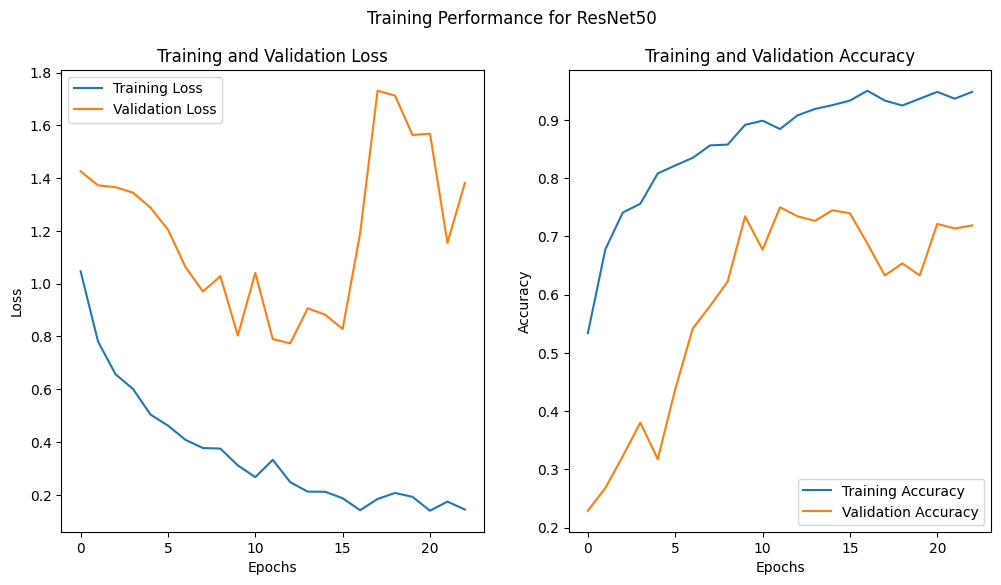

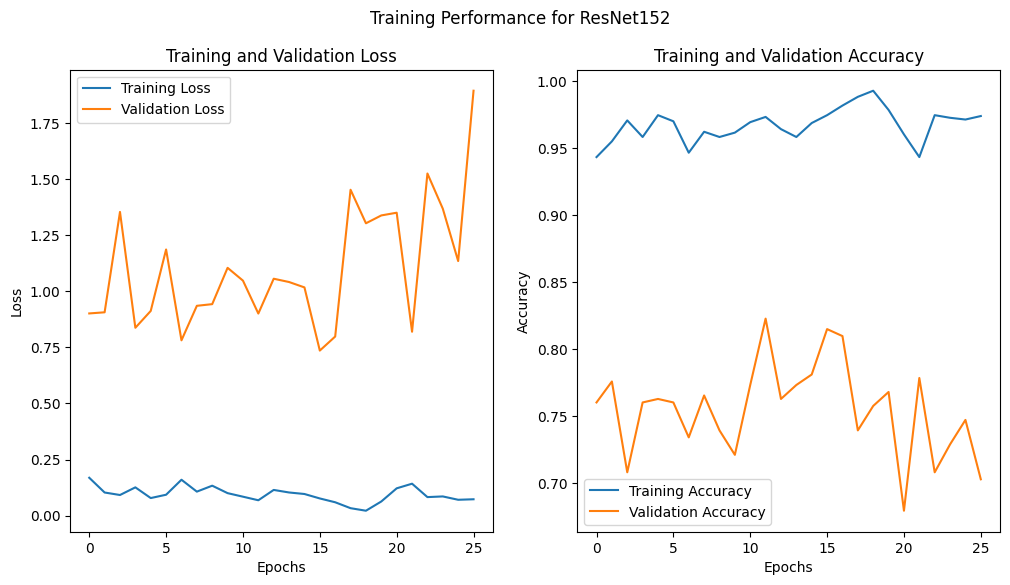

In [20]:
plot_model_performance(trained_resnet50_model, "Training Performance for ResNet50")
plot_model_performance(trained_resnet152_model, "Training Performance for ResNet152")